In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from datetime import datetime, timedelta
import requests
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
total_df = pd.read_csv('/content/drive/MyDrive/POSTECH 태양광 발전량 예측/DATA/total_df.csv')

In [ ]:
# 불필요한 feature 제거
total_df.drop(['Unnamed: 0'],axis=1, inplace = True)

In [ ]:
total_df.head(5)

,id,date,hour,group,temperature,humidity,dew_point,wind_dir,wind_spd,uv_idx,visibility,cloudiness,ceiling,pressure,precip_1h,amount
0,2,2020-10-01,1,1 / 2020-10-01 / 01,16.8,87.0,14.6,338.0,4.5,0.0,16.1,30.0,9144.0,1011.0,0.0,0.0
1,2,2020-10-01,2,1 / 2020-10-01 / 02,16.4,95.0,15.6,45.0,4.5,0.0,12.9,8.0,9144.0,1012.0,0.0,0.0
2,2,2020-10-01,3,1 / 2020-10-01 / 03,16.3,91.0,14.8,23.0,3.5,0.0,12.9,16.0,9144.0,1012.0,0.0,0.0
3,2,2020-10-01,4,1 / 2020-10-01 / 04,15.7,89.0,13.9,158.0,4.5,0.0,16.1,76.0,9144.0,1012.0,0.0,0.0
4,2,2020-10-01,5,1 / 2020-10-01 / 05,16.2,90.0,14.6,68.0,5.3,0.0,12.9,47.0,9144.0,1012.0,0.0,0.0


In [ ]:
df = total_df.copy()

df_hour7 = df[df['hour'] == 7]
df_hour8 = df[df['hour'] == 8]
df_hour9 = df[df['hour'] == 9]
df_hour10 = df[df['hour'] == 10]
df_hour11 = df[df['hour'] == 11]
df_hour12 = df[df['hour'] == 12]
df_hour13 = df[df['hour'] == 13]
df_hour14 = df[df['hour'] == 14]
df_hour15 = df[df['hour'] == 15]
df_hour16 = df[df['hour'] == 16]
df_hour17 = df[df['hour'] == 17]
df_hour18 = df[df['hour'] == 18]
df_hour19 = df[df['hour'] == 19]

In [ ]:
# 04에서의 유사성 검증 결론
# 1~6, 20~24 : 0으로 예측

# 7 : id = 5,4,16,7
# 8 : id = 4,5
# 9 : id = 18, 5, 11, 15
# 10 ~ 14 : id = 18,20
# 15 : 18,11,13,14 
# 16 : 18, 4, 17
# 17 : 18, 4
# 18 : 4, 18, 5
# 19 : 9, 4, 5

In [ ]:
# 유사성 기반 table 생성

df_hour7 = df_hour7[(df_hour7['id'] == 5) | (df_hour7['id'] == 4) | (df_hour7['id'] == 16) | (df_hour7['id'] == 7)]
df_hour8 = df_hour8[(df_hour8['id'] == 4) | (df_hour8['id'] == 5)]
df_hour9 = df_hour9[(df_hour9['id'] == 18) | (df_hour9['id'] == 5) | (df_hour9['id'] == 11) | (df_hour9['id'] == 15)]
df_hour10 = df_hour10[(df_hour10['id'] == 18) | (df_hour10['id'] == 20)]
df_hour11 = df_hour11[(df_hour11['id'] == 18) | (df_hour11['id'] == 20)]
df_hour12 = df_hour12[(df_hour12['id'] == 18) | (df_hour12['id'] == 20)]
df_hour13 = df_hour13[(df_hour13['id'] == 18) | (df_hour13['id'] == 20)]
df_hour14 = df_hour14[(df_hour14['id'] == 18) | (df_hour14['id'] == 20)]
df_hour15 = df_hour15[(df_hour15['id'] == 18) | (df_hour15['id'] == 11) | (df_hour15['id'] == 13) | (df_hour15['id'] == 14)]
df_hour16 = df_hour16[(df_hour16['id'] == 18) | (df_hour16['id'] == 4) | (df_hour16['id'] == 17)]
df_hour17 = df_hour17[(df_hour17['id'] == 18) | (df_hour17['id'] == 4)]
df_hour18 = df_hour18[(df_hour18['id'] == 18) | (df_hour18['id'] == 4) | (df_hour18['id'] == 5)]
df_hour19 = df_hour19[(df_hour19['id'] == 9) | (df_hour19['id'] == 4) | (df_hour19['id'] == 5)]

# 예측을 위한 함수 정의

In [ ]:
# 성능 평가 함수 정의

# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
# np.log() -> np.log1p() : np.log1p는 1+log() 값으로 log값에 1을 더해주어 underfitting/overfitting 위험성 감소

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mse_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MSE: {2:.3F}, R2 score: {2:.3F}'.format(rmsle_val, rmse_val, mse_val, r2_score(y,pred)))

## df_hour

In [ ]:
df_hour = df_hour16.copy()

In [ ]:
df_hour = df_hour.drop(['id','date','hour','group'],axis=1)

In [ ]:
df_hour.dropna(axis=0, inplace = True)

In [ ]:
df_hour.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2493 entries, 39999 to 326356
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  2493 non-null   float64
 1   humidity     2493 non-null   float64
 2   dew_point    2493 non-null   float64
 3   wind_dir     2493 non-null   float64
 4   wind_spd     2493 non-null   float64
 5   uv_idx       2493 non-null   float64
 6   visibility   2493 non-null   float64
 7   cloudiness   2493 non-null   float64
 8   ceiling      2493 non-null   float64
 9   pressure     2493 non-null   float64
 10  precip_1h    2493 non-null   float64
 11  amount       2493 non-null   float64
dtypes: float64(12)
memory usage: 253.2 KB


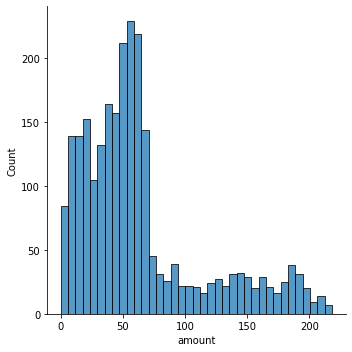

In [ ]:
sns.displot(df_hour['amount'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


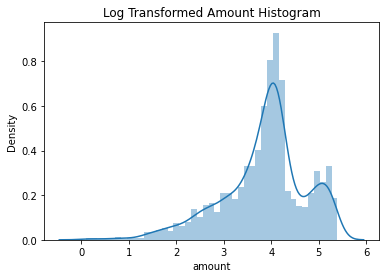

In [ ]:
# 로그 변환

plt.title('Log Transformed Amount Histogram')
log_Amount = np.log1p(df_hour['amount'])
sns.distplot(log_Amount)

In [ ]:
# target feature 로그 변환

df_hour['amount'] = np.log1p(df_hour['amount'])

### LinearRegression, Ridge, Lasso + MinMaxScaler

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = df_hour['amount']
X_features = df_hour.drop('amount',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

scalerX = MinMaxScaler()
scalerX.fit(X_train)
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

scalerY = MinMaxScaler()
scalerY.fit(y_train.reshape(-1,1))
y_train_scaled = scalerY.transform(y_train.reshape(-1,1))
y_test_scaled = scalerY.transform(y_test.reshape(-1,1))

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train_scaled, y_train_scaled)

y_train_hat_scaled_lr = lr_reg.predict(X_train_scaled)
y_train_hat_lr = scalerY.inverse_transform(y_train_hat_scaled_lr)
y_test_hat_scaled_lr = lr_reg.predict(X_test_scaled)
y_test_hat_lr = scalerY.inverse_transform(y_test_hat_scaled_lr)

evaluate_regr(y_train, y_train_hat_lr)
evaluate_regr(y_test, y_test_hat_lr)

ridge_reg = Ridge()
ridge_reg.fit(X_train_scaled, y_train_scaled)

y_train_hat_scaled_ridge = ridge_reg.predict(X_train_scaled)
y_train_hat_ridge = scalerY.inverse_transform(y_train_hat_scaled_ridge)
y_test_hat_scaled_ridge = ridge_reg.predict(X_test_scaled)
y_test_hat_ridge = scalerY.inverse_transform(y_test_hat_scaled_ridge)

evaluate_regr(y_train, y_train_hat_ridge)
evaluate_regr(y_test, y_test_hat_ridge)

lasso_reg = Lasso()
lasso_reg.fit(X_train_scaled, y_train_scaled)

y_train_hat_scaled_lasso = lasso_reg.predict(X_train_scaled)
y_train_hat_lasso = scalerY.inverse_transform(y_train_hat_scaled_lasso.reshape(1,-1))
y_test_hat_scaled_lasso = lasso_reg.predict(X_test_scaled)
y_test_hat_lasso = scalerY.inverse_transform(y_test_hat_scaled_lasso.reshape(-1,1))

y_train_hat_lasso = y_train_hat_lasso.reshape(-1,1)
y_test_hat_lasso = y_test_hat_lasso.reshape(-1,1)

evaluate_regr(y_train, y_train_hat_lasso)
evaluate_regr(y_test, y_test_hat_lasso)

RMSLE: 0.259, RMSE: 0.564, MSE: 0.430, R2 score: 0.430
RMSLE: 0.253, RMSE: 0.559, MSE: 0.445, R2 score: 0.445
RMSLE: 0.258, RMSE: 0.565, MSE: 0.431, R2 score: 0.431
RMSLE: 0.252, RMSE: 0.559, MSE: 0.444, R2 score: 0.444
RMSLE: 0.213, RMSE: 0.881, MSE: 0.657, R2 score: 0.657
RMSLE: 0.203, RMSE: 0.878, MSE: 0.676, R2 score: 0.676


### LinearRegression, Ridge, Lasso + No Scaling

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = df_hour['amount']
X_features = df_hour.drop('amount',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# scalerX = MinMaxScaler()
# scalerX.fit(X_train)
# X_train_scaled = scalerX.transform(X_train)
# X_test_scaled = scalerX.transform(X_test)

# y_train = np.asarray(y_train)
# y_test = np.asarray(y_test)

# scalerY = MinMaxScaler()
# scalerY.fit(y_train.reshape(-1,1))
# y_train_scaled = scalerY.transform(y_train.reshape(-1,1))
# y_test_scaled = scalerY.transform(y_test.reshape(-1,1))

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

y_train_hat_lr = lr_reg.predict(X_train)
# y_train_hat_lr = scalerY.inverse_transform(y_train_hat_scaled_lr)
y_test_hat_lr = lr_reg.predict(X_test)
# y_test_hat_lr = scalerY.inverse_transform(y_test_hat_scaled_lr)

evaluate_regr(y_train, y_train_hat_lr)
evaluate_regr(y_test, y_test_hat_lr)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

y_train_hat_ridge = ridge_reg.predict(X_train)
# y_train_hat_ridge = scalerY.inverse_transform(y_train_hat_scaled_ridge)
y_test_hat_ridge = ridge_reg.predict(X_test)
# y_test_hat_ridge = scalerY.inverse_transform(y_test_hat_scaled_ridge)

evaluate_regr(y_train, y_train_hat_ridge)
evaluate_regr(y_test, y_test_hat_ridge)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

y_train_hat_lasso = lasso_reg.predict(X_train)
# y_train_hat_lasso = scalerY.inverse_transform(y_train_hat_scaled_lasso.reshape(1,-1))
y_test_hat_lasso = lasso_reg.predict(X_test)
# y_test_hat_lasso = scalerY.inverse_transform(y_test_hat_scaled_lasso.reshape(-1,1))

evaluate_regr(y_train, y_train_hat_lasso)
evaluate_regr(y_test, y_test_hat_lasso)

RMSLE: 0.158, RMSE: 0.653, MSE: 0.526, R2 score: 0.526
RMSLE: 0.146, RMSE: 0.638, MSE: 0.524, R2 score: 0.524
RMSLE: 0.158, RMSE: 0.653, MSE: 0.526, R2 score: 0.526
RMSLE: 0.146, RMSE: 0.638, MSE: 0.524, R2 score: 0.524
RMSLE: 0.167, RMSE: 0.682, MSE: 0.533, R2 score: 0.533
RMSLE: 0.155, RMSE: 0.673, MSE: 0.545, R2 score: 0.545


In [ ]:
# LinearRegression
print('Linear Regression')
print(lr_reg.coef_)
print(lr_reg.intercept_)
print('\n')

print('Ridge Regression')
print(ridge_reg.coef_)
print(ridge_reg.intercept_)
print('\n')

print('Lasso Regression')
print(lasso_reg.coef_)
print(lasso_reg.intercept_)

Linear Regression
[-3.65149883e-02 -2.83365629e-02  4.98377139e-02  2.74404721e-04
 -3.87082115e-04  2.01686348e-01  5.27979426e-03 -4.57922620e-03
  1.00680229e-05 -1.91820169e-03 -1.56826634e-01]
7.308541252494027


Ridge Regression
[-3.64951333e-02 -2.83390790e-02  4.98324253e-02  2.74606185e-04
 -3.82697670e-04  2.01335010e-01  5.29124118e-03 -4.58178405e-03
  1.00924554e-05 -1.92685112e-03 -1.56407556e-01]
7.317277014011166


Lasso Regression
[ 1.04766821e-02 -1.11878207e-02  0.00000000e+00  2.58309645e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.40427208e-03
  4.21885449e-05 -0.00000000e+00 -0.00000000e+00]
4.144290921152876


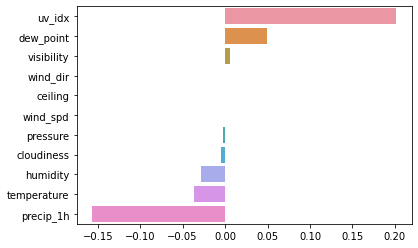

In [ ]:
# 각 feature의 회귀 계수 값 시각화 : LinearRegression
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

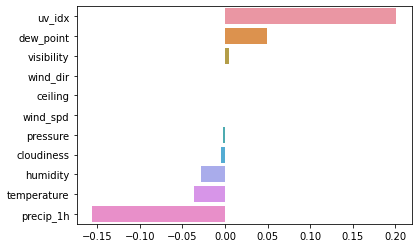

In [ ]:
# 각 feature의 회귀 계수 값 시각화 : Ridge
coef = pd.Series(ridge_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

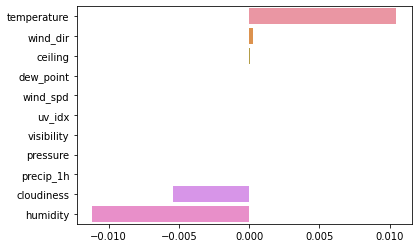

In [ ]:
# 각 feature의 회귀 계수 값 시각화 : Lasso
coef = pd.Series(lasso_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

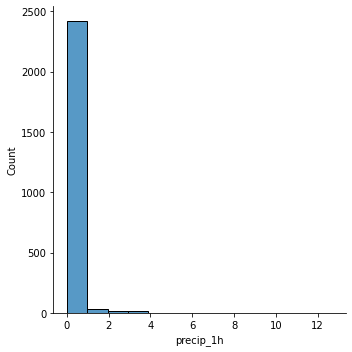

In [ ]:
sns.displot(df_hour['precip_1h'])

### 강수량(precip_1h) label encoding
* LinearRegression, Ridge, Lasso + No Scaling

In [ ]:
# 강수량 feature 0 or 1로 encoding 후 다시 진행

precip = df_hour['precip_1h']

precip = np.where(precip == 0, 0,
         np.where(precip < 3, 1,
                  np.where(precip < 15, 2, 3)))

df_hour['precip_1h'] = precip.copy()

In [ ]:
# 모델 예측 및 평가 일단 해보기

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = df_hour['amount']
X_features = df_hour.drop('amount',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# scalerX = MinMaxScaler()
# scalerX.fit(X_train)
# X_train_scaled = scalerX.transform(X_train)
# X_test_scaled = scalerX.transform(X_test)

# y_train = np.asarray(y_train)
# y_test = np.asarray(y_test)

# scalerY = MinMaxScaler()
# scalerY.fit(y_train.reshape(-1,1))
# y_train_scaled = scalerY.transform(y_train.reshape(-1,1))
# y_test_scaled = scalerY.transform(y_test.reshape(-1,1))

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

y_train_hat_lr = lr_reg.predict(X_train)
# y_train_hat_lr = scalerY.inverse_transform(y_train_hat_scaled_lr)
y_test_hat_lr = lr_reg.predict(X_test)
# y_test_hat_lr = scalerY.inverse_transform(y_test_hat_scaled_lr)

evaluate_regr(y_train, y_train_hat_lr)
evaluate_regr(y_test, y_test_hat_lr)

ridge_reg = Ridge(alpha = 0.5)
ridge_reg.fit(X_train, y_train)

y_train_hat_ridge = ridge_reg.predict(X_train)
# y_train_hat_ridge = scalerY.inverse_transform(y_train_hat_scaled_ridge)
y_test_hat_ridge = ridge_reg.predict(X_test)
# y_test_hat_ridge = scalerY.inverse_transform(y_test_hat_scaled_ridge)

evaluate_regr(y_train, y_train_hat_ridge)
evaluate_regr(y_test, y_test_hat_ridge)

lasso_reg = Lasso(alpha = 0.5)
lasso_reg.fit(X_train, y_train)

y_train_hat_lasso = lasso_reg.predict(X_train)
# y_train_hat_lasso = scalerY.inverse_transform(y_train_hat_scaled_lasso.reshape(1,-1))
y_test_hat_lasso = lasso_reg.predict(X_test)
# y_test_hat_lasso = scalerY.inverse_transform(y_test_hat_scaled_lasso.reshape(-1,1))

# evaluate_regr(y_train, y_train_hat_lasso)
# evaluate_regr(y_test, y_test_hat_lasso)

# 그냥 똑같다.

RMSLE: 0.158, RMSE: 0.653, MSE: 0.526, R2 score: 0.526
RMSLE: 0.146, RMSE: 0.638, MSE: 0.524, R2 score: 0.524
RMSLE: 0.158, RMSE: 0.653, MSE: 0.526, R2 score: 0.526
RMSLE: 0.146, RMSE: 0.638, MSE: 0.524, R2 score: 0.524


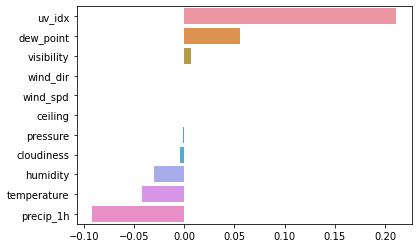

In [ ]:
# 각 feature의 회귀 계수 값 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

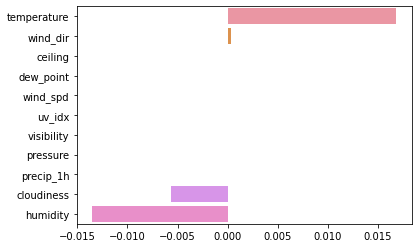

In [ ]:
# 각 feature의 회귀 계수 값 시각화
coef = pd.Series(lasso_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

### feature dependency 높은 것들(temperature) + precip_1h 제거
* LinearRegression, Ridge, Lasso + No Scaling

In [ ]:
# 모델 예측 및 평가 일단 해보기

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = df_hour['amount']
X_features = df_hour.drop(['amount','precip_1h','temperature'],axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# scalerX = MinMaxScaler()
# scalerX.fit(X_train)
# X_train_scaled = scalerX.transform(X_train)
# X_test_scaled = scalerX.transform(X_test)

# y_train = np.asarray(y_train)
# y_test = np.asarray(y_test)

# scalerY = MinMaxScaler()
# scalerY.fit(y_train.reshape(-1,1))
# y_train_scaled = scalerY.transform(y_train.reshape(-1,1))
# y_test_scaled = scalerY.transform(y_test.reshape(-1,1))

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

y_train_hat_lr = lr_reg.predict(X_train)
# y_train_hat_lr = scalerY.inverse_transform(y_train_hat_scaled_lr)
y_test_hat_lr = lr_reg.predict(X_test)
# y_test_hat_lr = scalerY.inverse_transform(y_test_hat_scaled_lr)

evaluate_regr(y_train, y_train_hat_lr)
evaluate_regr(y_test, y_test_hat_lr)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

y_train_hat_ridge = ridge_reg.predict(X_train)
# y_train_hat_ridge = scalerY.inverse_transform(y_train_hat_scaled_ridge)
y_test_hat_ridge = ridge_reg.predict(X_test)
# y_test_hat_ridge = scalerY.inverse_transform(y_test_hat_scaled_ridge)

evaluate_regr(y_train, y_train_hat_ridge)
evaluate_regr(y_test, y_test_hat_ridge)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

y_train_hat_lasso = lasso_reg.predict(X_train)
# y_train_hat_lasso = scalerY.inverse_transform(y_train_hat_scaled_lasso.reshape(1,-1))
y_test_hat_lasso = lasso_reg.predict(X_test)
# y_test_hat_lasso = scalerY.inverse_transform(y_test_hat_scaled_lasso.reshape(-1,1))

# evaluate_regr(y_train, y_train_hat_lasso)
# evaluate_regr(y_test, y_test_hat_lasso)

RMSLE: 0.159, RMSE: 0.656, MSE: 0.526, R2 score: 0.526
RMSLE: 0.147, RMSE: 0.639, MSE: 0.522, R2 score: 0.522
RMSLE: 0.159, RMSE: 0.656, MSE: 0.526, R2 score: 0.526
RMSLE: 0.147, RMSE: 0.639, MSE: 0.523, R2 score: 0.523


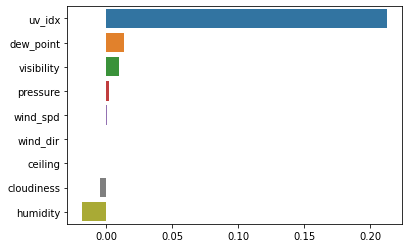

In [ ]:
# 각 feature의 회귀 계수 값 시각화 
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

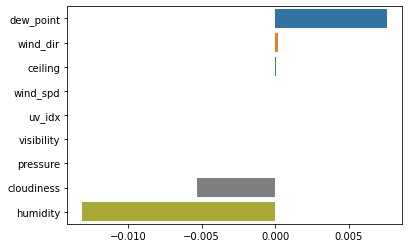

In [ ]:
# 각 feature의 회귀 계수 값 시각화
coef = pd.Series(lasso_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

### temperature만 제거

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = df_hour['amount']
X_features = df_hour.drop(['amount','temperature'],axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

scalerX = MinMaxScaler()
scalerX.fit(X_train)
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

scalerY = MinMaxScaler()
scalerY.fit(y_train.reshape(-1,1))
y_train_scaled = scalerY.transform(y_train.reshape(-1,1))
y_test_scaled = scalerY.transform(y_test.reshape(-1,1))

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train_scaled, y_train_scaled)

y_train_hat_scaled_lr = lr_reg.predict(X_train_scaled)
y_train_hat_lr = scalerY.inverse_transform(y_train_hat_scaled_lr)
y_test_hat_scaled_lr = lr_reg.predict(X_test_scaled)
y_test_hat_lr = scalerY.inverse_transform(y_test_hat_scaled_lr)

evaluate_regr(y_train, y_train_hat_lr)
evaluate_regr(y_test, y_test_hat_lr)

ridge_reg = Ridge()
ridge_reg.fit(X_train_scaled, y_train_scaled)

y_train_hat_scaled_ridge = ridge_reg.predict(X_train_scaled)
y_train_hat_ridge = scalerY.inverse_transform(y_train_hat_scaled_ridge)
y_test_hat_scaled_ridge = ridge_reg.predict(X_test_scaled)
y_test_hat_ridge = scalerY.inverse_transform(y_test_hat_scaled_ridge)

evaluate_regr(y_train, y_train_hat_ridge)
evaluate_regr(y_test, y_test_hat_ridge)

lasso_reg = Lasso()
lasso_reg.fit(X_train_scaled, y_train_scaled)

y_train_hat_scaled_lasso = lasso_reg.predict(X_train_scaled)
y_train_hat_lasso = scalerY.inverse_transform(y_train_hat_scaled_lasso.reshape(1,-1))
y_test_hat_scaled_lasso = lasso_reg.predict(X_test_scaled)
y_test_hat_lasso = scalerY.inverse_transform(y_test_hat_scaled_lasso.reshape(-1,1))

y_train_hat_lasso= y_train_hat_lasso.reshape(-1,1)
y_test_hat_lasso = y_test_hat_lasso.reshape(-1,1)

evaluate_regr(y_train, y_train_hat_lasso)
evaluate_regr(y_test, y_test_hat_lasso)

RMSLE: 0.248, RMSE: 0.655, MSE: 0.527, R2 score: 0.527
RMSLE: 0.238, RMSE: 0.636, MSE: 0.520, R2 score: 0.520
RMSLE: 0.247, RMSE: 0.655, MSE: 0.526, R2 score: 0.526
RMSLE: 0.238, RMSE: 0.636, MSE: 0.520, R2 score: 0.520
RMSLE: 0.213, RMSE: 0.881, MSE: 0.657, R2 score: 0.657
RMSLE: 0.203, RMSE: 0.878, MSE: 0.676, R2 score: 0.676


## MODEL

### RandomForestRegressor

In [ ]:
y_target = df_hour['amount']
X_features = df_hour.drop('amount',axis=1, inplace=False)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# fit
rf_reg = RandomForestRegressor(n_estimators=200, bootstrap=True)
rf_reg.fit(X_train, y_train)

# # scaling
# scalerX = MinMaxScaler()
# scalerX.fit(X_train)
# X_train_scaled = scalerX.transform(X_train)
# X_test_scaled = scalerX.transform(X_test)

# y_train = np.asarray(y_train)
# y_test = np.asarray(y_test)

# scalerY = MinMaxScaler()
# scalerY.fit(y_train.reshape(-1,1))
# y_train_scaled = scalerY.transform(y_train.reshape(-1,1))
# y_test_scaled = scalerY.transform(y_test.reshape(-1,1))

# predict
y_train_hat_rf = rf_reg.predict(X_train)
y_test_hat_rf = rf_reg.predict(X_test)

evaluate_regr(y_train, y_train_hat_rf)
evaluate_regr(y_test, y_test_hat_rf)

RMSLE: 0.063, RMSE: 0.233, MSE: 0.179, R2 score: 0.179
RMSLE: 0.138, RMSE: 0.603, MSE: 0.490, R2 score: 0.490


### GradientBoostingRegression (GBM) + MinMaxscaling

In [ ]:
y_target = df_hour['amount']
X_features = df_hour.drop('amount',axis=1, inplace=False)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# scaling
scalerX = MinMaxScaler()
scalerX.fit(X_train)
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

scalerY = MinMaxScaler()
scalerY.fit(y_train.reshape(-1,1))
y_train_scaled = scalerY.transform(y_train.reshape(-1,1))
y_test_scaled = scalerY.transform(y_test.reshape(-1,1))

# fit
gbm_reg = GradientBoostingRegressor(n_estimators=500)
gbm_reg.fit(X_train_scaled, y_train_scaled)

# predict
y_train_hat_scaled_gbm = gbm_reg.predict(X_train_scaled)
y_train_hat_gbm = scalerY.inverse_transform(y_train_hat_scaled_gbm.reshape(1,-1))
y_test_hat_scaled_gbm = gbm_reg.predict(X_test_scaled)
y_test_hat_gbm = scalerY.inverse_transform(y_test_hat_scaled_gbm.reshape(1,-1))

y_train_hat_gbm = y_train_hat_gbm.reshape(-1,1)
y_test_hat_gbm = y_test_hat_gbm.reshape(-1,1)

evaluate_regr(y_train, y_train_hat_gbm)
evaluate_regr(y_test, y_test_hat_gbm)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSLE: 0.274, RMSE: 0.367, MSE: 0.287, R2 score: 0.287
RMSLE: 0.254, RMSE: 0.614, MSE: 0.501, R2 score: 0.501


### GradientBoostingRegression (GBM) + No scaling

In [ ]:
y_target = df_hour['amount']
X_features = df_hour.drop('amount',axis=1, inplace=False)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# fit
gbm_reg = GradientBoostingRegressor(n_estimators=500)
gbm_reg.fit(X_train, y_train)

# predict
y_train_hat_gbm = gbm_reg.predict(X_train)
y_test_hat_gbm = gbm_reg.predict(X_test)

evaluate_regr(y_train, y_train_hat_gbm)
evaluate_regr(y_test, y_test_hat_gbm)

RMSLE: 0.083, RMSE: 0.367, MSE: 0.287, R2 score: 0.287
RMSLE: 0.139, RMSE: 0.617, MSE: 0.502, R2 score: 0.502


### XGB Regression

In [ ]:
y_target = df_hour['amount']
X_features = df_hour.drop('amount',axis=1, inplace=False)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# scaling
scalerX = MinMaxScaler()
scalerX.fit(X_train)
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

scalerY = MinMaxScaler()
scalerY.fit(y_train.reshape(-1,1))
y_train_scaled = scalerY.transform(y_train.reshape(-1,1))
y_test_scaled = scalerY.transform(y_test.reshape(-1,1))

# fit
xgb_reg = XGBRegressor(n_estimators=500)
xgb_reg.fit(X_train_scaled, y_train_scaled)

# predict
y_train_hat_scaled_xgb = xgb_reg.predict(X_train_scaled)
y_train_hat_xgb = scalerY.inverse_transform(y_train_hat_scaled_xgb.reshape(1,-1))
y_test_hat_scaled_xgb = xgb_reg.predict(X_test_scaled)
y_test_hat_xgb = scalerY.inverse_transform(y_test_hat_scaled_xgb.reshape(1,-1))

y_train_hat_xgb = y_train_hat_xgb.reshape(-1,1)
y_test_hat_xgb = y_test_hat_xgb.reshape(-1,1)

evaluate_regr(y_train, y_train_hat_xgb)
evaluate_regr(y_test, y_test_hat_xgb)

[06:47:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE: 0.272, RMSE: 0.378, MSE: 0.294, R2 score: 0.294
RMSLE: 0.252, RMSE: 0.617, MSE: 0.501, R2 score: 0.501


In [ ]:
y_target = df_hour['amount']
X_features = df_hour.drop('amount',axis=1, inplace=False)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# scaling
scalerX = MinMaxScaler()
scalerX.fit(X_train)
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

scalerY = MinMaxScaler()
scalerY.fit(y_train.reshape(-1,1))
y_train_scaled = scalerY.transform(y_train.reshape(-1,1))
y_test_scaled = scalerY.transform(y_test.reshape(-1,1))

# fit
lgbm_reg = LGBMRegressor(n_estimators=500)
lgbm_reg.fit(X_train_scaled, y_train_scaled)

# predict
y_train_hat_scaled_lgbm = lgbm_reg.predict(X_train_scaled)
y_train_hat_lgbm = scalerY.inverse_transform(y_train_hat_scaled_lgbm.reshape(1,-1))
y_test_hat_scaled_lgbm = lgbm_reg.predict(X_test_scaled)
y_test_hat_lgbm = scalerY.inverse_transform(y_test_hat_scaled_lgbm.reshape(1,-1))

y_train_hat_lgbm = y_train_hat_lgbm.reshape(-1,1)
y_test_hat_lgbm = y_test_hat_lgbm.reshape(-1,1)

evaluate_regr(y_train, y_train_hat_lgbm)
evaluate_regr(y_test, y_test_hat_lgbm)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSLE: 0.292, RMSE: 0.101, MSE: 0.077, R2 score: 0.077
RMSLE: 0.256, RMSE: 0.647, MSE: 0.527, R2 score: 0.527


### DecisionTreeRegressor

In [ ]:
# 모델 예측 및 평가

from sklearn.tree import DecisionTreeRegressor

y_target = df_hour['amount']
X_features = df_hour.drop(['amount','temperature'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.4, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
dt_reg = DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 5, random_state = 0)
dt_reg.fit(X_train, y_train)

y_train_hat_dt = dt_reg.predict(X_train)
y_test_hat_dt = dt_reg.predict(X_test)

evaluate_regr(y_train, y_train_hat_dt)
evaluate_regr(y_test, y_test_hat_dt)

RMSLE: 0.113, RMSE: 0.454, MSE: 0.346, R2 score: 0.346
RMSLE: 0.172, RMSE: 0.732, MSE: 0.561, R2 score: 0.561


In [ ]:
# 모델 예측 및 평가

from sklearn.tree import DecisionTreeRegressor

y_target = df_hour['amount']
X_features = df_hour.drop(['amount','temperature'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.4, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
dt_reg = DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 5, random_state = 0)
dt_reg.fit(X_train, y_train)

y_train_hat_dt = dt_reg.predict(X_train)
y_test_hat_dt = dt_reg.predict(X_test)

evaluate_regr(y_train, y_train_hat_dt)
evaluate_regr(y_test, y_test_hat_dt)

RMSLE: 0.113, RMSE: 0.454, MSE: 0.346, R2 score: 0.346
RMSLE: 0.172, RMSE: 0.732, MSE: 0.561, R2 score: 0.561


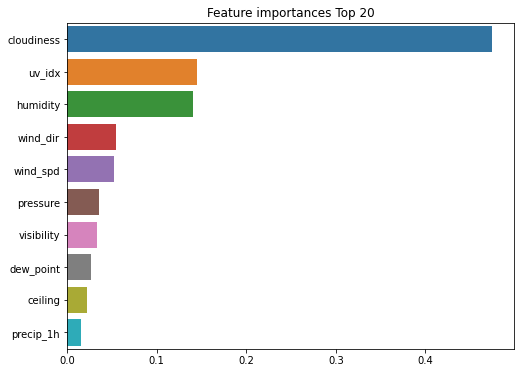

In [ ]:
# feature 중요도 체크 

import seaborn as sns

ftr_importances_values = dt_reg.feature_importances_

# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()